In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip show tensorflow
#!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn import model_selection
import os
import nibabel as nib
import cv2
import numpy as np
!pip install simpleitk
import SimpleITK as sitk


img_path = "drive/MyDrive/Progetto_IA_L_Gianvittorio/DATASET_Lorenza/4.DATASET_MRI+ADNI_MERGE_REG" 
img_height, img_width = 256, 256 
seq_len = 5


# Read
def read_img(img_path):
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

# Resample to 1 mm
def resample_img(itk_image, out_spacing=[1, 1, 1], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(itk_image)

def preprocess(img, out_shape=None):
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Input normalization
    mean = img.mean() 
    std = img.std()
    return (img - mean) / std


X = []
Y = []

d = img_path
classes = ["AD","CN"]
classes_list = os.listdir(d) 
print(classes_list)
print(classes_list[0]) # CN
print(classes_list[1]) # AD

full_path = os.path.join(d,classes_list[0]) 
for p2 in os.listdir(full_path): 
  p3 = os.path.join(full_path,p2) 
  my_img = nib.load(p3) 
  nii_data = my_img.get_fdata() 
  my_img.uncache()
  del my_img
  temp = []
  for i in range(0,5): 
    temp.append(cv2.resize(nii_data[:,:,i],(256,256)))
  X.append(temp)
  y = [0]*len(classes_list)
  y[0] = 1
  Y.append(y) # label [1,0] 

full_path1 = os.path.join(d,classes_list[1]) 
for p2 in os.listdir(full_path1): 
  p3 = os.path.join(full_path1,p2) 
  my_img = nib.load(p3) 
  nii_data = my_img.get_fdata() 
  my_img.uncache()
  del my_img
  temp = []
  for i in range(0,5): 
    temp.append(cv2.resize(nii_data[:,:,i],(256,256)))
  X.append(temp)
  y = [0]*len(classes_list)
  y[1] = 1
  Y.append(y) # label [0,1]

['CN_MRI+ADNI_MERGE', 'AD_MRI+ADNI_MERGE']


In [ ]:
X = np.asarray(X)
Y = np.asarray(Y)

X = X[...,np.newaxis]
print(X.shape)

(427, 5, 256, 256, 1)


In [ ]:
X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, test_size = 0.20, shuffle = True, random_state = 0)

print("Number of training samples: " + str(len(X_train)))
print("Number of test samples: " + str(len(X_test)))

del X
del Y

Number of training samples: 341
Number of test samples: 86


In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/Progetto_IA_L_Gianvittorio/Selene/4paper/Best_model/OASIS3+ADNI1S_CNvsAD_bestmodel.h5') 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 254, 254, 32)      38144     
_________________________________________________________________
dropout_2 (Dropout)          (None, 254, 254, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2064512)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               528515328 
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 528,553,986
Trainable params: 528,553,986
Non-trainable params: 0
________________________________________

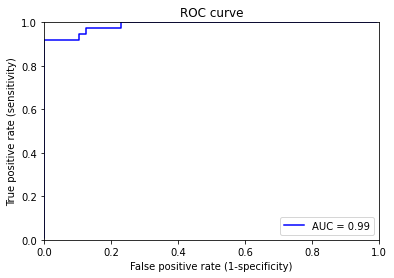

In [ ]:
# ROC+AUC 
import sklearn.metrics as metrics

# Calculate the fpr and tpr for ALL thresholds of the classification
probs = model.predict(X_test)
preds = probs[:,1]

Y_test = np.argmax(Y_test, axis = 1)

fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot
import matplotlib.pyplot as plt
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'w--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True positive rate (sensitivity)')
plt.xlabel('False positive rate (1-specificity)')
plt.show()